Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [6]:
pip install tensorflow==2.15

In [55]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.layers import BatchNormalization

from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [8]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [9]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/CNN_Assignment'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [10]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [12]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 5184 files belonging to 9 classes.
Using 4148 files for training.


In [13]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 5184 files belonging to 9 classes.
Using 1036 files for validation.


In [14]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

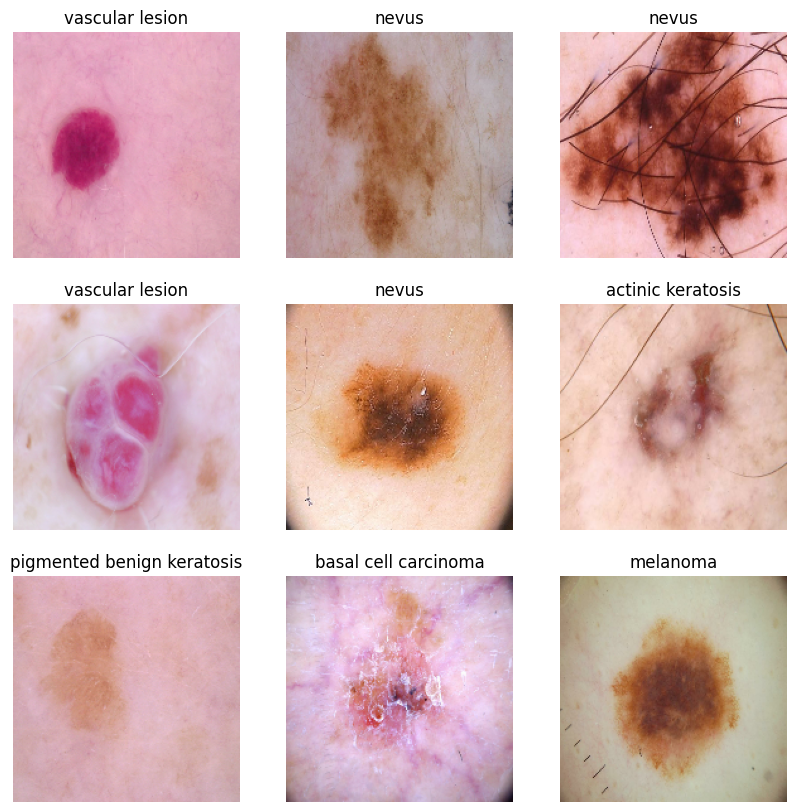

In [15]:
# ### your code goes here, you can use training or validation data to visualize

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [18]:
### Your code goes here
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [19]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

### Train the model

In [23]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
130/130 [==============================] - 12s 91ms/step - loss: 1.5380 - accuracy: 0.4221 - val_loss: 1.6419 - val_accuracy: 0.4131
Epoch 2/20
130/130 [==============================] - 12s 92ms/step - loss: 1.4256 - accuracy: 0.4749 - val_loss: 1.4252 - val_accuracy: 0.4788
Epoch 3/20
130/130 [==============================] - 12s 92ms/step - loss: 1.3390 - accuracy: 0.5176 - val_loss: 1.3402 - val_accuracy: 0.5290
Epoch 4/20
130/130 [==============================] - 12s 91ms/step - loss: 1.2148 - accuracy: 0.5697 - val_loss: 1.3280 - val_accuracy: 0.5319
Epoch 5/20
130/130 [==============================] - 12s 91ms/step - loss: 1.1313 - accuracy: 0.6058 - val_loss: 1.3402 - val_accuracy: 0.5270
Epoch 6/20
130/130 [==============================] - 12s 96ms/step - loss: 1.0494 - accuracy: 0.6324 - val_loss: 1.2875 - val_accuracy: 0.5840
Epoch 7/20
130/130 [==============================] - 12s 91ms/step - loss: 0.9261 - accuracy: 0.6808 - val_loss: 1.1584 - val_accuracy:

### Visualizing training results

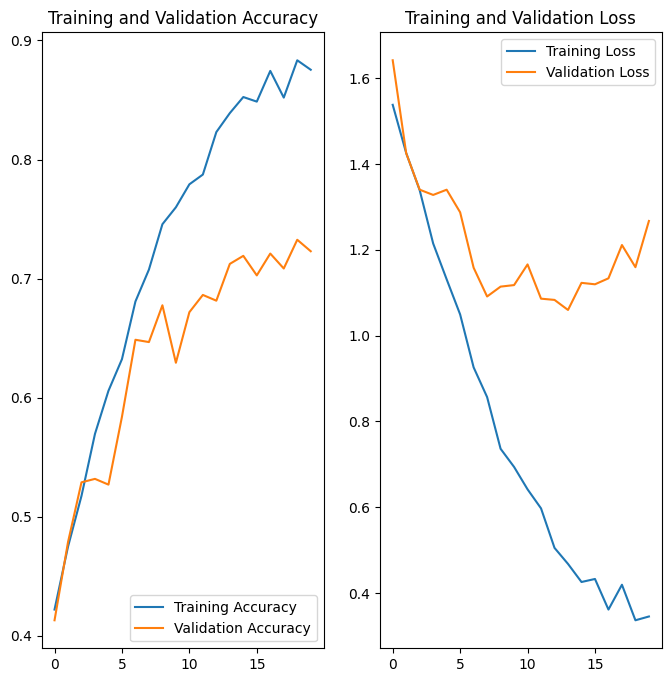

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

1. **Improvement in Accuracy**: The model's accuracy on both the training and validation sets improved over the epochs. The training accuracy increased from **42.21%** in the first epoch to **87.54%** in the last epoch. Similarly, the validation accuracy improved from **41.31%** to **72.30%**. This indicates that the model was learning and improving its performance over time.

2. **Validation Loss Fluctuation**: The validation loss decreased initially, reaching its lowest at **1.0599** in the 14th epoch, but then it started to increase, reaching **1.2673** in the 20th epoch. This could be a sign of overfitting, where the model performs well on the training data but not as well on unseen data (validation set). It might be beneficial to introduce some regularization techniques or early stopping to prevent this.

In [25]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

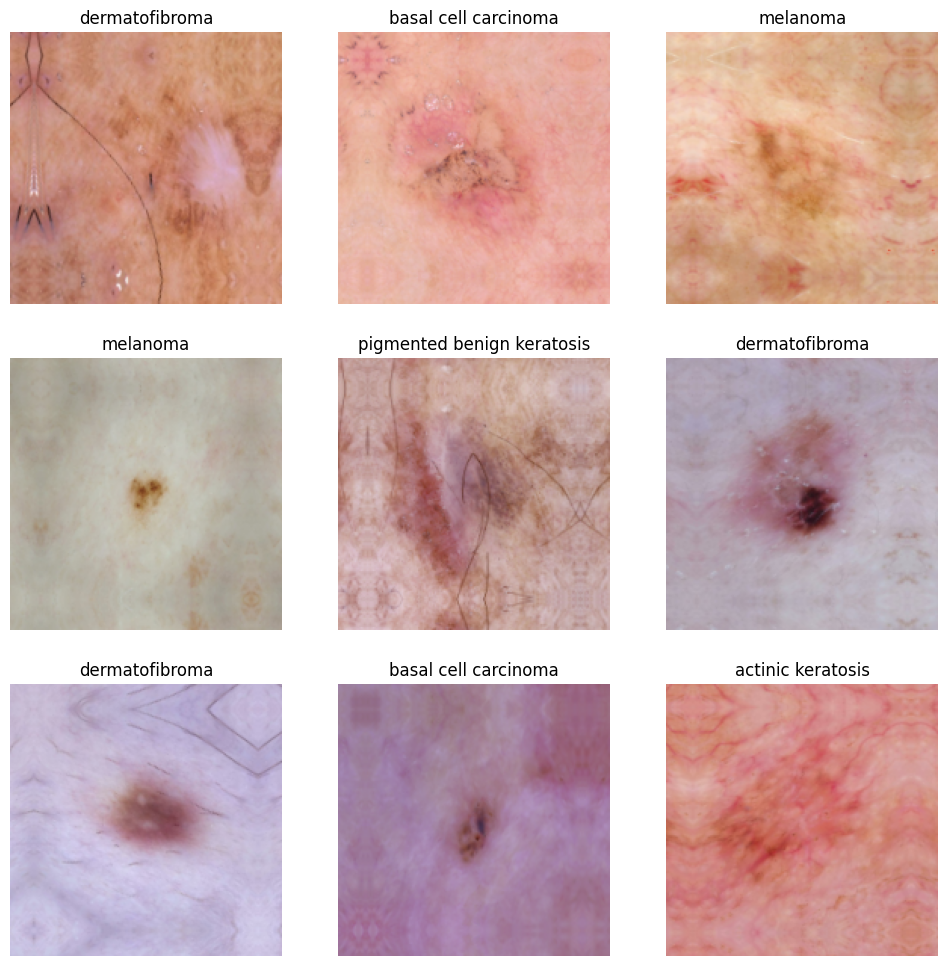

In [26]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [51]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [28]:
### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [30]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
130/130 [==============================] - 14s 106ms/step - loss: 2.0830 - accuracy: 0.1902 - val_loss: 1.9998 - val_accuracy: 0.2037
Epoch 2/20
130/130 [==============================] - 13s 102ms/step - loss: 1.9870 - accuracy: 0.1866 - val_loss: 1.9930 - val_accuracy: 0.2249
Epoch 3/20
130/130 [==============================] - 13s 102ms/step - loss: 1.9835 - accuracy: 0.1859 - val_loss: 1.9947 - val_accuracy: 0.2037
Epoch 4/20
130/130 [==============================] - 13s 102ms/step - loss: 1.9836 - accuracy: 0.1902 - val_loss: 1.9936 - val_accuracy: 0.2037
Epoch 5/20
130/130 [==============================] - 13s 101ms/step - loss: 1.9819 - accuracy: 0.1965 - val_loss: 1.9968 - val_accuracy: 0.1892
Epoch 6/20
130/130 [==============================] - 13s 101ms/step - loss: 1.9801 - accuracy: 0.1873 - val_loss: 1.9983 - val_accuracy: 0.2442
Epoch 7/20
130/130 [==============================] - 13s 102ms/step - loss: 1.9777 - accuracy: 0.2064 - val_loss: 1.9987 - val_ac

### Visualizing the results

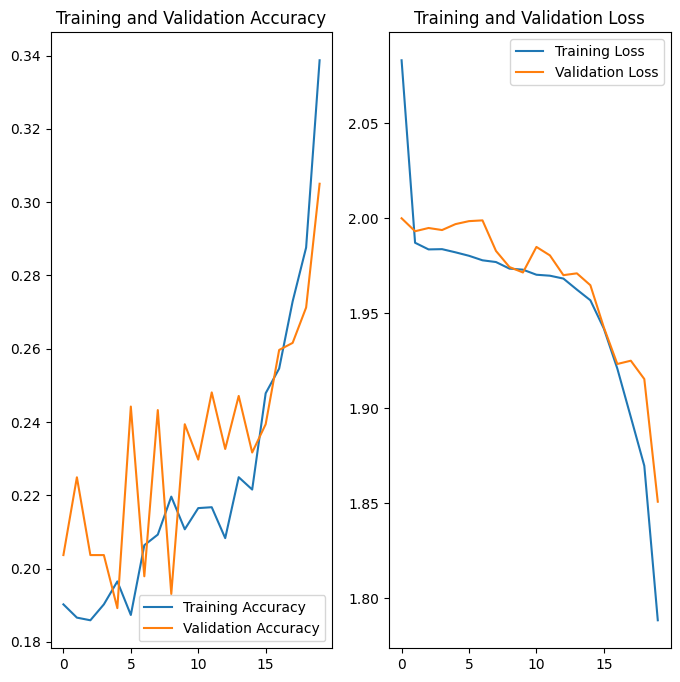

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Finding from Second Model**

1. **Slow Improvement in Accuracy**: The model's accuracy on both the training and validation sets improved over the epochs, but the improvement was slow. The training accuracy increased from **19.02%** in the first epoch to **33.87%** in the last epoch. Similarly, the validation accuracy improved from **20.37%** to **30.50%**. This indicates that the model was learning and improving its performance over time, but the rate of improvement was slow.

2. **High Loss Values**: The loss values for both the training and validation sets remained high throughout the training process. Even though the loss decreased from **2.0830** to **1.7883** on the training set and from **1.9998** to **1.8507** on the validation set, these values are still relatively high. This suggests that the model might need further optimization or a different approach to improve its performance.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [32]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNN_Assignment/Train/a...,actinic keratosis
1,/content/gdrive/MyDrive/CNN_Assignment/Train/a...,actinic keratosis
2,/content/gdrive/MyDrive/CNN_Assignment/Train/a...,actinic keratosis
3,/content/gdrive/MyDrive/CNN_Assignment/Train/a...,actinic keratosis
4,/content/gdrive/MyDrive/CNN_Assignment/Train/a...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/CNN_Assignment/Train/v...,vascular lesion
2235,/content/gdrive/MyDrive/CNN_Assignment/Train/v...,vascular lesion
2236,/content/gdrive/MyDrive/CNN_Assignment/Train/v...,vascular lesion
2237,/content/gdrive/MyDrive/CNN_Assignment/Train/v...,vascular lesion


<BarContainer object of 9 artists>

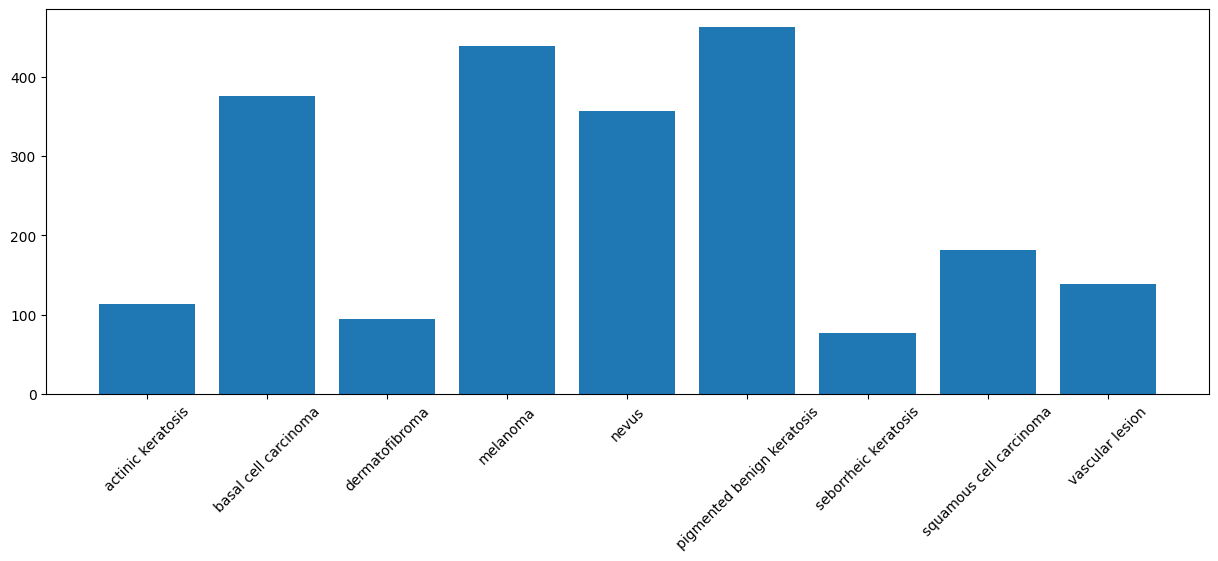

In [33]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
plt.bar(class_names,count)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

#### Answer-1 :- seborrheic keratosis

#### Answer-2 :- melanoma and pigmented benign keratosis



In [34]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [35]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [37]:
path_to_training_dataset= "/content/gdrive/MyDrive/CNN_Assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AA1323F3F10>: 100%|██████████| 500/500 [00:21<00:00, 23.28 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA13277A0E0>: 100%|██████████| 500/500 [00:22<00:00, 22.58 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA13253FBE0>: 100%|██████████| 500/500 [00:22<00:00, 21.99 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7AA1407E7B50>: 100%|██████████| 500/500 [01:30<00:00,  5.54 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA1404B7880>: 100%|██████████| 500/500 [01:14<00:00,  6.73 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA15B9AFE80>: 100%|██████████| 500/500 [00:18<00:00, 27.30 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AA1324A31C0>: 100%|██████████| 500/500 [00:39<00:00, 12.64 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA132475960>: 100%|██████████| 500/500 [00:17<00:00, 28.16 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA1B8475780>: 100%|██████████| 500/500 [00:20<00:00, 24.63 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

7945


### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN_Assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031609.jpg_41543708-7d1d-41c9-a97c-8d31b82c16b6.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033494.jpg_474cd48e-c20f-4145-abc7-61731cf54e98.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027447.jpg_3b59f03b-a51c-41ae-a0bc-3dfe035c6828.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030463.jpg_37f89c43-899a-4049-9db4-9e082e43c598.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029133.jpg_99fbf4df-a0ab-48a1-9d98-007ec2e33996.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031040.jpg_93f511c0-7c10-4bd2-b74a-ca0971ca64a7.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Train

In [40]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [41]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [43]:
new_df['Label'].value_counts()

Label
actinic keratosis             1585
basal cell carcinoma          1085
dermatofibroma                1085
melanoma                      1085
nevus                         1085
pigmented benign keratosis     505
seborrheic keratosis           505
squamous cell carcinoma        505
vascular lesion                505
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [44]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [45]:
data_dir_train="/content/gdrive/MyDrive/CNN_Assignment/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10184 files belonging to 9 classes.
Using 8148 files for training.


#### **Todo:** Create a validation dataset

In [57]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10184 files belonging to 9 classes.
Using 2036 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [62]:
### Your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_45 (ModuleW  (None, 178, 178, 32)      896       
 rapper)                                                         
                                                                 
 module_wrapper_46 (ModuleW  (None, 176, 176, 32)      9248      
 rapper)                                                         
                                                                 
 module_wrapper_47 (ModuleW  (None, 88, 88, 32)        0         
 rapper)                                                         
                                                                 
 module_wrapper_48 (ModuleW  (None, 86, 86, 64)        18496     
 rapper)                                             

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [64]:
## your code goes here
optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [65]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_45 (ModuleW  (None, 178, 178, 32)      896       
 rapper)                                                         
                                                                 
 module_wrapper_46 (ModuleW  (None, 176, 176, 32)      9248      
 rapper)                                                         
                                                                 
 module_wrapper_47 (ModuleW  (None, 88, 88, 32)        0         
 rapper)                                                         
                                                                 
 module_wrapper_48 (ModuleW  (None, 86, 86, 64)        18496     
 rapper)                                             

#### **Todo:**  Train your model

In [66]:
epochs = 30

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/30
255/255 [==============================] - 73s 253ms/step - loss: -2886954.2500 - accuracy: 0.1426 - val_loss: -9726735.0000 - val_accuracy: 0.1469 - lr: 0.0010
Epoch 2/30
255/255 [==============================] - 63s 239ms/step - loss: -38370172.0000 - accuracy: 0.1426 - val_loss: -74418832.0000 - val_accuracy: 0.1469 - lr: 0.0010
Epoch 3/30
255/255 [==============================] - 61s 236ms/step - loss: -155091248.0000 - accuracy: 0.1426 - val_loss: -166876448.0000 - val_accuracy: 0.1469 - lr: 0.0010
Epoch 4/30
254/255 [============================>.] - ETA: 0s - loss: -397358976.0000 - accuracy: 0.1428
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
255/255 [==============================] - 64s 245ms/step - loss: -398135712.0000 - accuracy: 0.1426 - val_loss: -1389407744.0000 - val_accuracy: 0.1469 - lr: 0.0010
Epoch 5/30
255/255 [==============================] - 62s 237ms/step - loss: -677646272.0000 - accuracy: 0.1426 - val_loss: -785197

#### **Todo:**  Visualize the model results

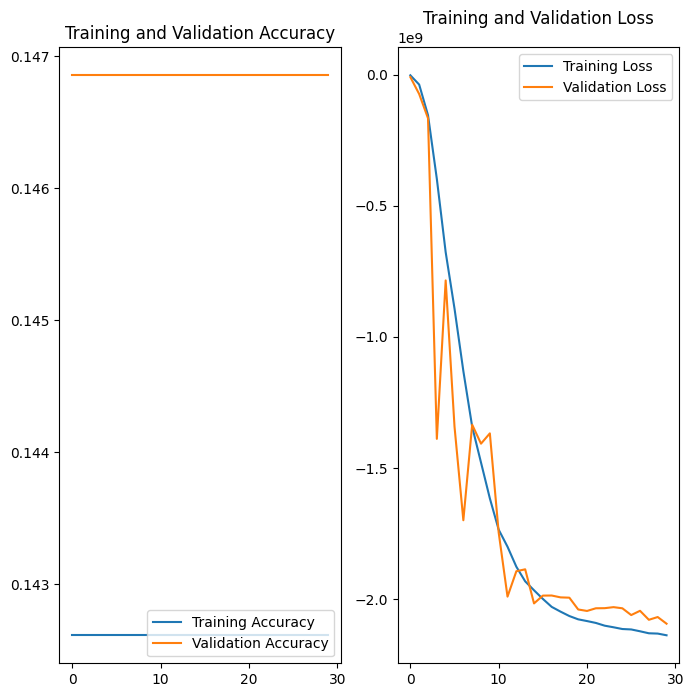

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



1. **Constant Accuracy**: The model's accuracy on both the training and validation sets remains constant throughout the 30 epochs at around **14.26%** and **14.69%** respectively. This indicates that the model is not learning effectively from the training process.

2. **Negative Loss Values**: The loss values for both the training and validation sets are negative and decreasing rapidly. This is unusual as loss values are typically positive and a model's goal is to minimize this value. Negative loss values could indicate an issue with how loss is being calculated or reported.

3. **Learning Rate Adjustment**: The learning rate is being reduced at certain epochs (4, 7, 10, etc.) as part of a strategy to refine the learning process. However, despite these adjustments, the model's accuracy does not improve, suggesting that the model or the data may need to be revised.

4. **Validation Loss vs Training Loss**: The validation loss is consistently lower than the training loss. This is unusual as we would typically expect the model to perform better on the training data than on the unseen validation data. This could be due to the negative loss values reported.

5. **Underfitting/Overfitting**: The model does not appear to be overfitting as the validation loss and accuracy are not showing a significant divergence from the training loss and accuracy. However, the model does seem to be underfitting. Despite running for 30 epochs, the accuracy remains constant and low (around 14.26% for training and 14.69% for validation), indicating that the model is not learning effectively from the training data.